In [ ]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
def make_sample(data, window, target_col_index):
  sequences = []
  targets = []
  for i in range(len(data) - window):
    sequences.append(data[i : i + window]) # 입력: (window, 특성 수)
    targets.append(data[i + window, target_col_index]) # 타겟: 다음 시점의 특정 특성 값
  return np.array(sequences), np.array(targets).reshape(-1, 1) # 타겟 형태를 (샘플 수, 1)로

In [ ]:
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/AAME.csv"
csv_data = requests.get(url).text
df = pd.read_csv(StringIO(csv_data))

In [ ]:
features = ['Open', 'High', 'Low', 'Close']
ohlc_data = df[features].values

In [ ]:
scaler = MinMaxScaler()
ohlc_data_scaled = scaler.fit_transform(ohlc_data)

In [ ]:
WINDOW_SIZE_MULTI = 10 # RNN 입력 윈도우 크기
NUM_FEATURES = len(features) # 특성 개수, 여기서는 4
TARGET_COLUMN_NAME = 'Close' # 예측할 대상 컬럼
target_col_idx = features.index(TARGET_COLUMN_NAME) # 'Close' 컬럼의 인덱스 (3)

In [ ]:
train_data_raw_multi = ohlc_data_scaled[:8000]
test_data_raw_multi = ohlc_data_scaled[8000:] # 실제 데이터 길이 고려하여 조정 가능
print(f"스케일링된 전체 데이터 형태: {ohlc_data_scaled.shape}")
print(f"훈련용 데이터 형태: {train_data_raw_multi.shape}")
print(f"테스트용 데이터 형태: {test_data_raw_multi.shape}")

스케일링된 전체 데이터 형태: (10098, 4)
훈련용 데이터 형태: (8000, 4)
테스트용 데이터 형태: (2098, 4)


In [ ]:
x_train, y_train = make_sample(train_data_raw_multi, WINDOW_SIZE_MULTI, target_col_idx)
x_test, y_test = make_sample(test_data_raw_multi, WINDOW_SIZE_MULTI, target_col_idx)

## RNN

In [ ]:
model = Sequential()
# input_shape은 (타임스텝 수, 피처 수) 입니다.
# 타임스텝 수 = WINDOW_SIZE_MULTI, 피처 수 = NUM_FEATURES
model.add(SimpleRNN(10, activation='tanh', input_shape=(WINDOW_SIZE_MULTI, NUM_FEATURES)))
model.add(Dense(1, activation='tanh')) # 다음 날의 'Close' 가격 (스케일된 값) 하나를 예측
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs=50, # 에포크 수 (조정 가능)
    batch_size=32, # 배치 크기 (조정 가능)
    validation_data=(x_test, y_test),
    verbose=1 # 학습 과정 출력 (0:출력안함, 1:막대바, 2:에포크당 한줄)
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0022 - val_loss: 1.6914e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6971e-04 - val_loss: 8.3403e-05
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1787e-04 - val_loss: 4.7658e-05
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9109e-04 - val_loss: 5.1700e-05
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5432e-04 - val_loss: 4.0890e-05
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4089e-04 - val_loss: 4.5775e-05
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3941e-04 - val_loss: 7.5853e-05
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2621e-04 - val_loss: 4.0600e-05
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1665e-04 - val_loss: 4.0147e-05
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2184e-04 - val_loss: 4.2513e-05
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.

In [ ]:
predicted_scaled = model.predict(x_test) # 결과는 스케일링된 값 (샘플 수, 1)

# 예측값 복원
# 임시 배열을 만들어 'Close' 컬럼 위치(target_col_idx)에 예측값을 넣음
temp_predicted = np.zeros((len(predicted_scaled), NUM_FEATURES))
temp_predicted[:, target_col_idx] = predicted_scaled.flatten()
predicted_original_scale = scaler.inverse_transform(temp_predicted)[:, target_col_idx]

# 실제값(y_test) 복원
temp_y_test = np.zeros((len(y_test), NUM_FEATURES))
temp_y_test[:, target_col_idx] = y_test.flatten()
y_test_original_scale = scaler.inverse_transform(temp_y_test)[:, target_col_idx]

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [ ]:
# 1. MSE (Mean Squared Error) - 평균 제곱 오차
mse = mean_squared_error(y_test_original_scale, predicted_original_scale)
print(f"평균 제곱 오차 (MSE): {mse:.4f}")

# 2. RMSE (Root Mean Squared Error) - 평균 제곱근 오차
rmse = np.sqrt(mse)
print(f"평균 제곱근 오차 (RMSE): {rmse:.4f}")

# 3. MAE (Mean Absolute Error) - 평균 절대 오차
mae = mean_absolute_error(y_test_original_scale, predicted_original_scale)
print(f"평균 절대 오차 (MAE): {mae:.4f}")

# 4. MAPE (Mean Absolute Percentage Error) - 평균 절대 백분율 오차
non_zero_actuals_mask = y_test_original_scale.flatten() != 0
if np.sum(non_zero_actuals_mask) > 0:
    mape = np.mean(np.abs((y_test_original_scale[non_zero_actuals_mask] - predicted_original_scale[non_zero_actuals_mask]) / y_test_original_scale[non_zero_actuals_mask])) * 100
    print(f"평균 절대 백분율 오차 (MAPE): {mape:.2f}%")
else:
    print("MAPE: 실제 값에 0이 아닌 값이 없어 계산할 수 없습니다.")

# 5. R-squared (R² Score, 결정 계수)
r2 = r2_score(y_test_original_scale, predicted_original_scale)
print(f"결정 계수 (R-squared): {r2:.4f}")

평균 제곱 오차 (MSE): 0.0089
평균 제곱근 오차 (RMSE): 0.0942
평균 절대 오차 (MAE): 0.0629
평균 절대 백분율 오차 (MAPE): 1.99%
결정 계수 (R-squared): 0.9816


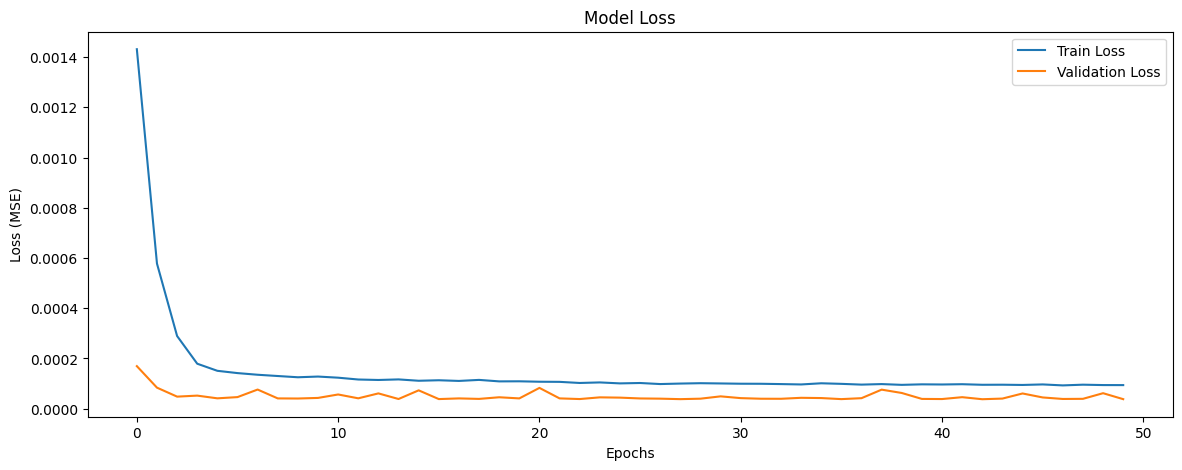

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

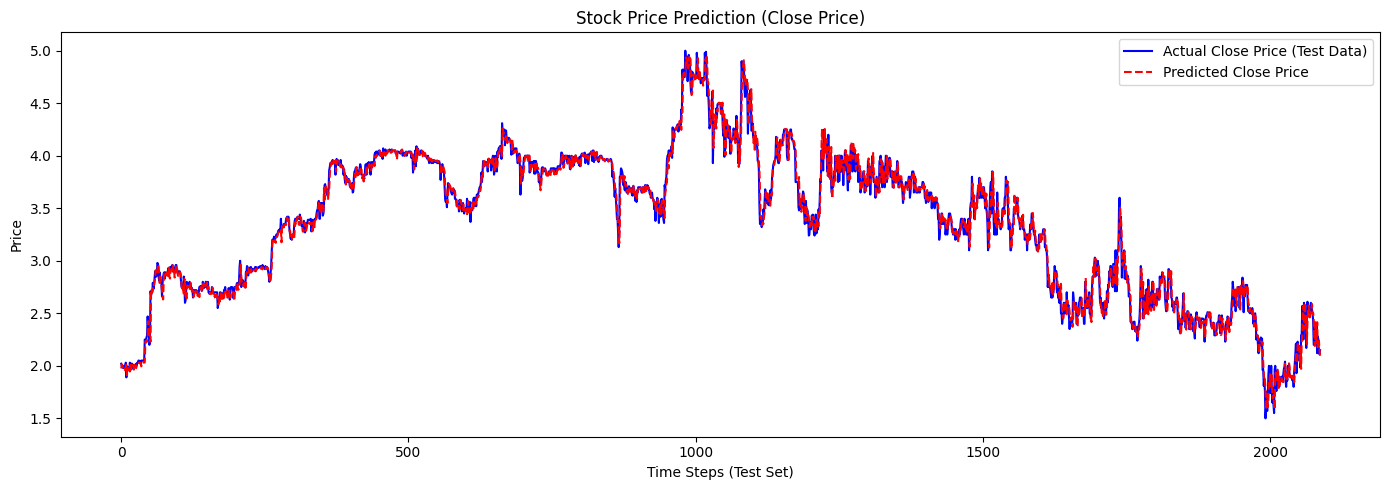

In [ ]:
# 실제 값과 예측 값 비교 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test_original_scale, label='Actual Close Price (Test Data)', color='blue')
plt.plot(predicted_original_scale, label='Predicted Close Price', color='red', linestyle='--')
plt.title('Stock Price Prediction (Close Price)')
plt.xlabel('Time Steps (Test Set)')
plt.ylabel('Price')
plt.legend()

plt.tight_layout() # 그래프들이 겹치지 않도록 조정
plt.show()

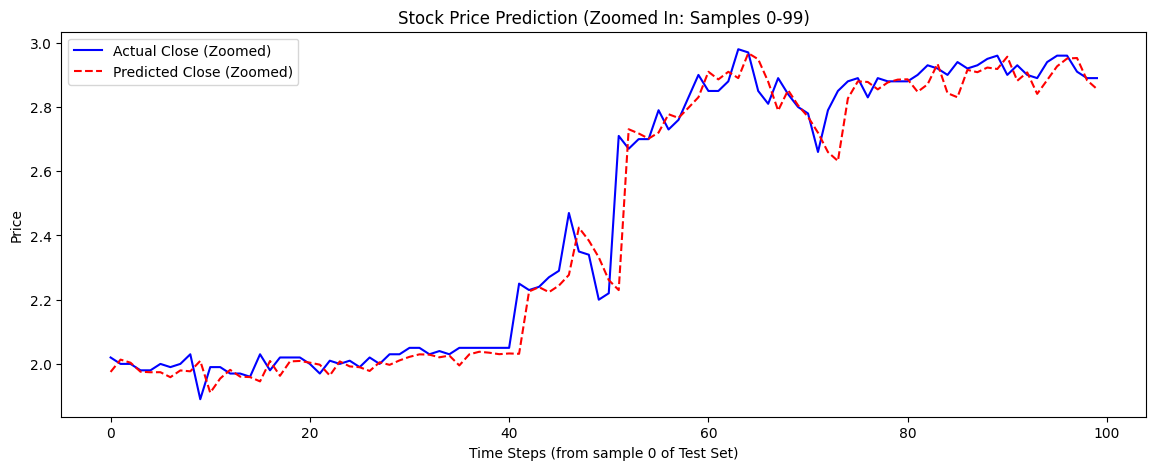

In [ ]:
# 확대할 범위 설정 (예: 테스트 데이터의 처음 100개 포인트)
zoom_start_index = 0
zoom_end_index = 100 # 이 값을 조절하여 확대 범위를 변경하세요.
                     # zoom_end_index는 len(y_test_original_scale) 보다 작아야 합니다.
if zoom_end_index > len(y_test_original_scale):
    zoom_end_index = len(y_test_original_scale) # 범위를 벗어나지 않도록 조정

plt.figure(figsize=(14, 5))
# x축을 위한 인덱스 배열 (0부터 시작하도록)
time_steps_zoomed = np.arange(zoom_end_index - zoom_start_index)

plt.plot(time_steps_zoomed, y_test_original_scale[zoom_start_index:zoom_end_index], label='Actual Close (Zoomed)', color='blue')
plt.plot(time_steps_zoomed, predicted_original_scale[zoom_start_index:zoom_end_index], label='Predicted Close (Zoomed)', color='red', linestyle='--')
plt.title(f'Stock Price Prediction (Zoomed In: Samples {zoom_start_index}-{zoom_end_index-1})')
plt.xlabel(f'Time Steps (from sample {zoom_start_index} of Test Set)')
plt.ylabel('Price')
plt.legend()

## LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(10, activation='tanh', input_shape=(WINDOW_SIZE_MULTI, NUM_FEATURES)))
model_lstm.add(Dense(1, activation='tanh'))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()


--- LSTM 모델 구조 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611 (2.39 KB)

 Trainable params: 611 (2.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nLSTM 모델 학습 시작...")
history_lstm = model_lstm.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=1
)
print("LSTM 모델 학습 완료.")


LSTM 모델 학습 시작...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0150 - val_loss: 1.4101e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.1609e-04 - val_loss: 1.1451e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6563e-04 - val_loss: 9.0328e-05
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9152e-04 - val_loss: 8.7551e-05
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5234e-04 - val_loss: 7.9941e-05
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2083e-04 - val_loss: 7.3311e-05
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0367e-04 - val_loss: 6.2578e-05
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.9826e-04 - val_loss: 5.9082e-05
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8418e-04 - val_loss: 5.7660e-05
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6342e-04 - val_loss: 5.6175e-05
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
predicted_scaled_lstm = model_lstm.predict(x_test)

# 예측값 복원 (LSTM)
temp_predicted_lstm = np.zeros((len(predicted_scaled_lstm), NUM_FEATURES))
temp_predicted_lstm[:, target_col_idx] = predicted_scaled_lstm.flatten()
predicted_original_scale_lstm = scaler.inverse_transform(temp_predicted_lstm)[:, target_col_idx]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
mse_lstm = mean_squared_error(y_test_original_scale, predicted_original_scale_lstm)
print(f"평균 제곱 오차 (MSE) - LSTM: {mse_lstm:.4f}")
rmse_lstm = np.sqrt(mse_lstm)
print(f"평균 제곱근 오차 (RMSE) - LSTM: {rmse_lstm:.4f}")
mae_lstm = mean_absolute_error(y_test_original_scale, predicted_original_scale_lstm)
print(f"평균 절대 오차 (MAE) - LSTM: {mae_lstm:.4f}")

non_zero_actuals_mask_lstm = y_test_original_scale.flatten() != 0
if np.sum(non_zero_actuals_mask_lstm) > 0:
    mape_lstm = np.mean(np.abs((y_test_original_scale[non_zero_actuals_mask_lstm] - predicted_original_scale_lstm[non_zero_actuals_mask_lstm]) / y_test_original_scale[non_zero_actuals_mask_lstm])) * 100
    print(f"평균 절대 백분율 오차 (MAPE) - LSTM: {mape_lstm:.2f}%")
else:
    print("MAPE - LSTM: 실제 값에 0이 아닌 값이 없어 계산할 수 없습니다.")

r2_lstm = r2_score(y_test_original_scale, predicted_original_scale_lstm)
print(f"결정 계수 (R-squared) - LSTM: {r2_lstm:.4f}")

평균 제곱 오차 (MSE) - LSTM: 0.0087
평균 제곱근 오차 (RMSE) - LSTM: 0.0932
평균 절대 오차 (MAE) - LSTM: 0.0632
평균 절대 백분율 오차 (MAPE) - LSTM: 2.00%
결정 계수 (R-squared) - LSTM: 0.9820


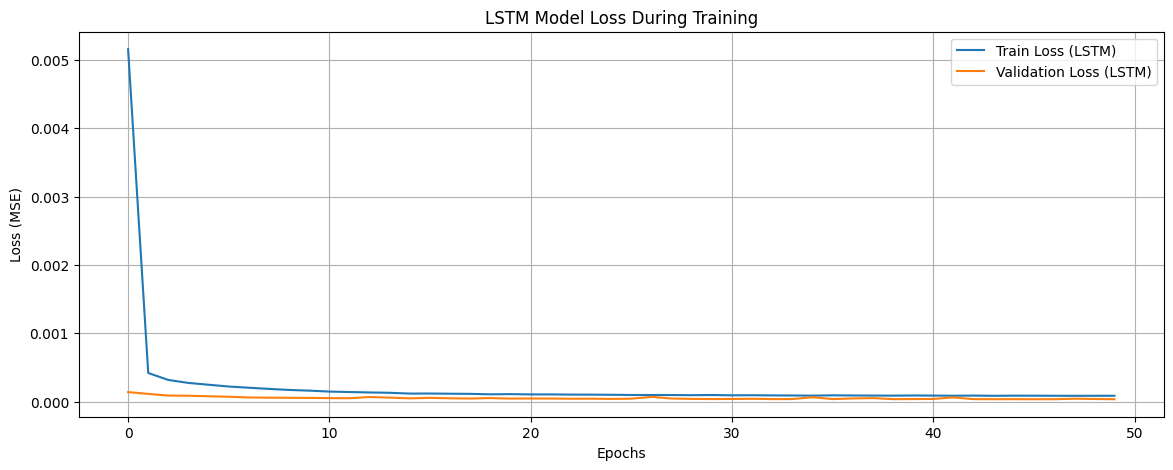

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)')
plt.title('LSTM Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

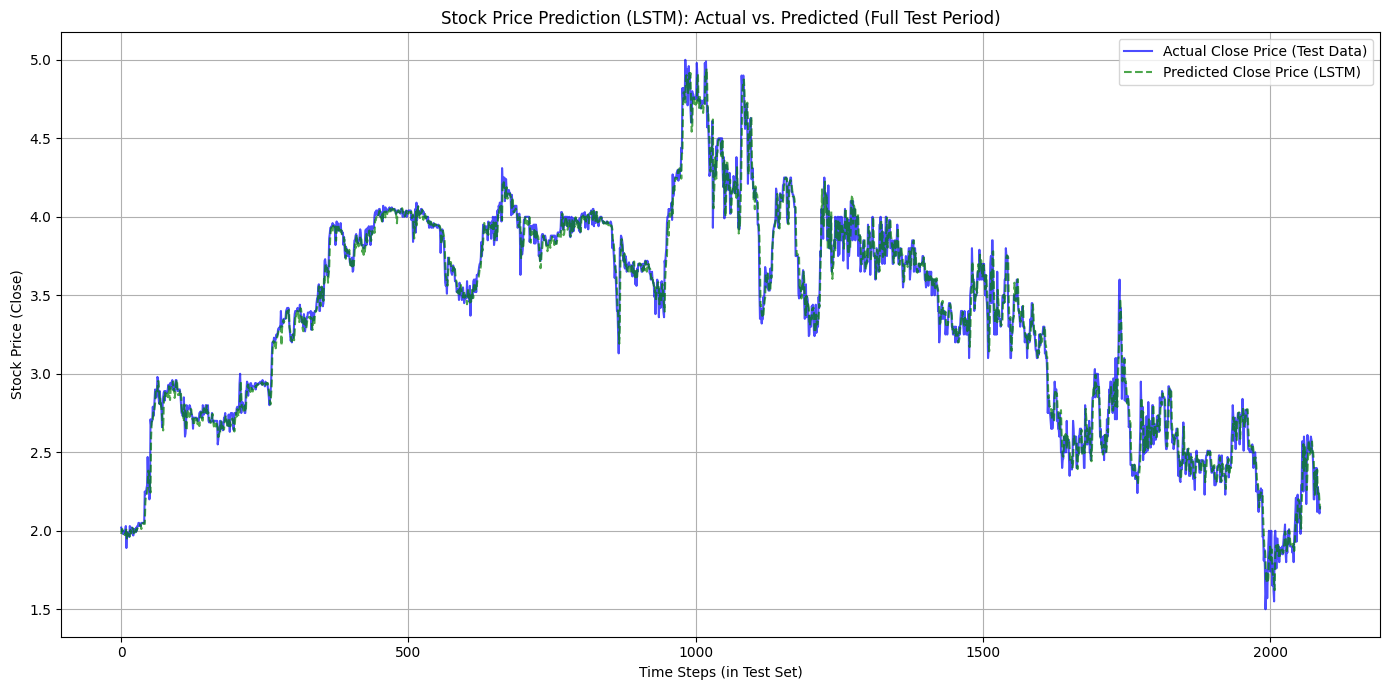

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_original_scale, label='Actual Close Price (Test Data)', color='blue', alpha=0.7)
plt.plot(predicted_original_scale_lstm, label='Predicted Close Price (LSTM)', color='green', linestyle='--', alpha=0.7) # 색상 변경 등
plt.title('Stock Price Prediction (LSTM): Actual vs. Predicted (Full Test Period)')
plt.xlabel('Time Steps (in Test Set)')
plt.ylabel('Stock Price (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

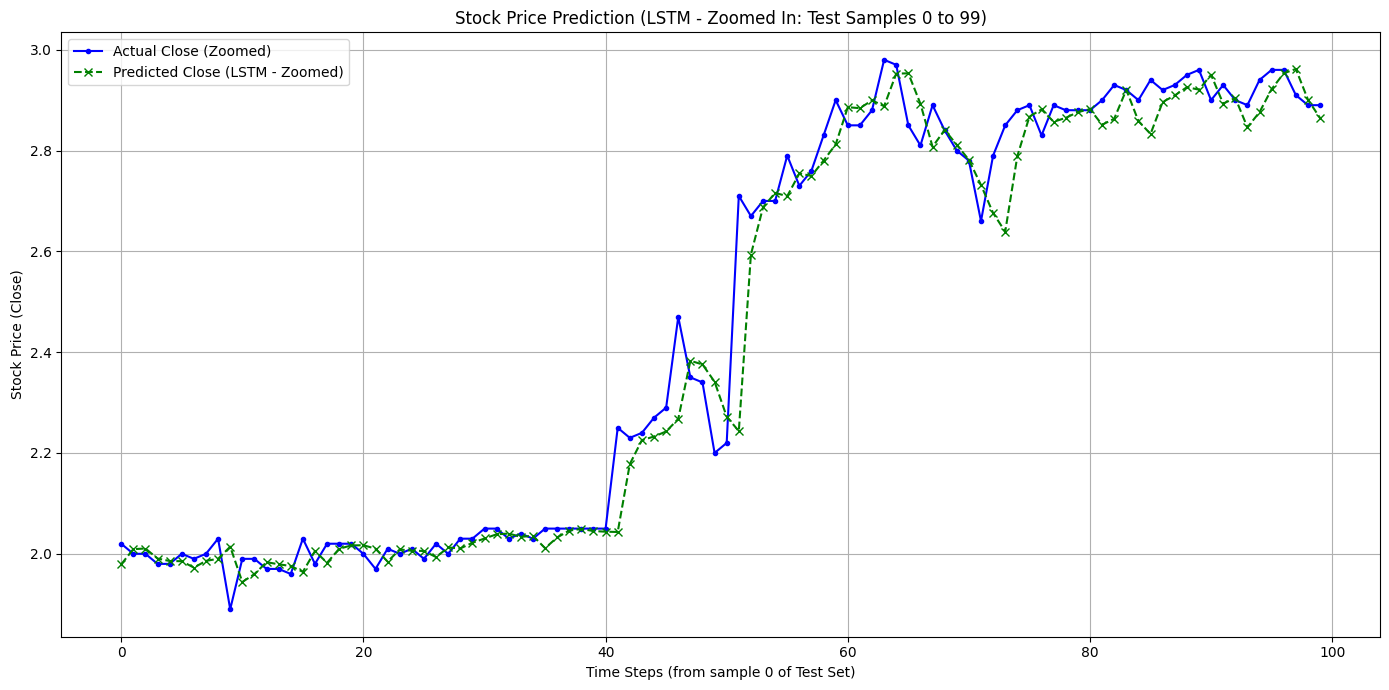

In [ ]:
zoom_start_index_lstm = 0
zoom_end_index_lstm = 100
if zoom_end_index_lstm > len(y_test_original_scale):
    zoom_end_index_lstm = len(y_test_original_scale)

plt.figure(figsize=(14, 7))
time_steps_zoomed_lstm = np.arange(zoom_end_index_lstm - zoom_start_index_lstm)

plt.plot(time_steps_zoomed_lstm, y_test_original_scale[zoom_start_index_lstm:zoom_end_index_lstm], label='Actual Close (Zoomed)', color='blue', marker='.')
plt.plot(time_steps_zoomed_lstm, predicted_original_scale_lstm[zoom_start_index_lstm:zoom_end_index_lstm], label='Predicted Close (LSTM - Zoomed)', color='green', linestyle='--', marker='x')
plt.title(f'Stock Price Prediction (LSTM - Zoomed In: Test Samples {zoom_start_index_lstm} to {zoom_end_index_lstm-1})')
plt.xlabel(f'Time Steps (from sample {zoom_start_index_lstm} of Test Set)')
plt.ylabel('Stock Price (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()